In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
cmap = cm.get_cmap('Paired')
from DFA import DFAHelper as dfah
from Backtester import SignalHelper as sh
from Backtester.SignalLibrary import Signals as sl
from Portfolio import PortHelper as ph
from cryptocmd import CmcScraper
from sklearn.decomposition import PCA


In [3]:
crypto_tickers = ['BTC','DASH','DCR', 'DOGE','ETC', 'ETH', 'LTC',
                  'XRP', 'XEM', 'XMR', 'ZEC', 'ADA', 'DOT', 'SOL',
                  'AVAX', 'MATIC', 'LINK', 'BCH','UNI', 'ATOM', 'PIVX']

crypto_dict = {}
crypto_price_dict = {}
crypto_df = pd.DataFrame(columns=crypto_tickers)
for ticker in crypto_tickers:
    scraper = CmcScraper(ticker,order_ascending=True)
    df = scraper.get_dataframe()
    df.index = df['Date']
    df.drop(columns='Date', inplace=True)
    crypto_price_dict[ticker] = df['Close']
    crypto_dict[ticker] = df.copy()
crypto_df = pd.DataFrame.from_dict(crypto_price_dict)
sub_cryptos = crypto_df.columns[(crypto_df.isnull().sum() < 1500)]

In [4]:
def get_sigmoid_size(z, z_thresh=2, ls=True):
    pdf_signal = 1/(1 + np.exp(-z))
    pdf_thresh = 1/(1 + np.exp(-z_thresh))
    
    long_out_size = np.minimum(np.maximum(pdf_signal, 1-pdf_thresh), pdf_thresh)
    if ls: return 2*long_out_size - 1
    else: return long_out_size
    

def get_signal_weights(lkbks, alpha):
    sig_w = alpha**np.array(lkbks)
    sig_w = sig_w/sig_w.sum()
    return sig_w

def get_stationary_block_samples(data, m, t, M):
    
    accept = 1/m
    len_data = len(data)
    sample_ix = np.random.randint(len_data)
    sample = np.zeros((t, M)).astype(int)
    for sim in range(M):
        for ix in range(t):
            if np.random.uniform() > accept:
                sample_ix = sample_ix + 1
                if sample_ix > len_data-1:
                    sample_ix = 0
            else:
                sample_ix = np.random.randint(len_data)
            sample[ix, sim] = sample_ix
    return sample

def get_strat_rets(df, vol_tgt=0.30):

    vols = (df.ewm(span=126, min_periods=21).std()*np.sqrt(252)).dropna()
    position_size = (((df+1).cumprod().to_frame().apply(get_bo_sig)+1)/2).multiply((vol_tgt/vols), axis=0)
    return position_size.shift(1).multiply(df.squeeze(), axis=0)[df.name]

def get_stats(x, tau):
    
    curve = (1+x).dropna().cumprod()
    return pd.Series(
        [
            x.mean()*tau, curve.iloc[-1]**(tau/len(x))-1,
            x.std()*np.sqrt(tau), 
            x.mean()*np.sqrt(tau)/x.std(),
            x.mean()*np.sqrt(len(x.dropna()))/x.std(), 
            ph.get_skill_ratio(x.dropna(), tau), 
            (curve/curve.cummax()-1).abs().max(),
            (x.mean()*tau)/(curve/curve.cummax()-1).abs().max(),
            x.skew(), x.kurtosis()
        ], 
        index = ['Arith. Mean', 'Compound Mean', 'Volatility',
                 'SR', 't-Stat', 'Skew Sharpe', 'Max DD', 'Calmar','Skewness', 'Kurtosis']
        )

def get_ramom_cta(df, 
                  ls=False,
                  tsmom_lkbks = [10, 20, 30, 40, 50],
                  alpha=0.94,):
    
    ra_mom = pd.concat({lkbk: df.pct_change().rolling(lkbk).mean().\
                        divide(df.ewm(span=lkbk).std()) for lkbk in tsmom_lkbks}, axis=1)
    ra_mom = ra_mom.divide(ra_mom.ewm(span=252, min_periods=21).std())
    
    sig_w = get_signal_weights(tsmom_lkbks, alpha)
    cta_sig = ra_mom.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig

def get_emac_cta(df,
                 ls=False,
                 lkbks=[[5, 20], [10, 40], [20, 80]],
                 weight_factors=[5, 10, 20], 
                 alpha=0.94):
    
    sig_w = get_signal_weights(weight_factors, alpha)
    emac_z_df = pd.concat(
                {
                    'emac_' + str(lkbk[0]) + '_' + str(lkbk[1]):
                    
                    (df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[0]))).mean().\
                            subtract(df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[1]))).mean())).divide(
                            df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[1]))).std()
                    )
                    for lkbk in lkbks
                }, axis=1)
    cta_sig = emac_z_df.divide(emac_z_df.ewm(span=252, min_periods=21).std())
    cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig
    
def get_emabo_cta(df, 
                  ls=False,
                  ema_lkbks=[10, 20, 30, 40, 50], 
                  alpha=0.94):
    
    sig_w = get_signal_weights(ema_lkbks, alpha)
    breakout_z = pd.concat({lkbk: (df - df.ewm(span=lkbk, min_periods=21).mean().shift(1)).\
                                      divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                                  for lkbk in ema_lkbks}, axis=1)
    cta_sig = breakout_z.divide(breakout_z.ewm(span=252, min_periods=21).std())
    cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig

def get_max_breakout_cta(df,
                         ls=False,
                         max_lkbks = [10, 20, 30, 40, 50],
                         alpha=0.94):

    sig_w = get_signal_weights(max_lkbks, alpha)
    max_breakout_sig = pd.concat({lkbk: (df - df.rolling(lkbk).max().shift(1)).\
                                  divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                                 for lkbk in max_lkbks}, axis=1)
    cta_sig = max_breakout_sig.divide(max_breakout_sig.ewm(span=252, min_periods=21).std())
    cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    return cta_sig


In [78]:
crypto_rets = crypto_df[sub_cryptos].pct_change().dropna(how='all').copy()
ret_stats = crypto_rets.apply(get_stats, args=(252,))
ret_stats

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XRP,XEM,XMR,ZEC,PIVX
Arith. Mean,0.662214,1.213555,1.083081,1.472341,1.229609,1.239059,0.756535,1.060080,1.351372,1.008740,0.423864,1.708612
Compound Mean,0.552221,0.546655,0.379738,0.605278,0.327265,0.713848,0.283114,0.454483,0.586635,0.481821,-0.179454,0.508422
Volatility,0.666178,1.381428,1.138256,1.734288,1.556833,0.994519,1.060989,1.255992,1.326816,1.081224,1.285964,1.562564
SR,0.994051,0.878479,0.951527,0.848960,0.789814,1.245888,0.713047,0.844018,1.018507,0.932961,0.329608,1.093467
t-Stat,3.584648,3.023454,2.848911,2.951562,2.276738,3.881565,2.571321,2.997760,3.255129,3.158908,0.927868,3.271712
Skew Sharpe,0.686092,0.823828,0.995326,0.767341,0.712943,0.871493,0.485396,0.578130,0.703899,0.977154,0.330079,0.758711
Max DD,0.845285,0.974289,0.924331,0.952671,0.921167,0.939625,0.974136,0.958661,0.983154,0.955391,0.984917,0.986782
Calmar,0.783421,1.245580,1.171746,1.545487,1.334838,1.318673,0.776622,1.105792,1.374528,1.055840,0.430355,1.731500
Skewness,0.246404,10.046059,1.430426,15.051174,17.431604,0.137572,4.084140,5.546599,4.631009,1.395076,5.751135,2.343858
Kurtosis,10.081407,261.754907,8.240946,426.856750,566.410014,14.627630,63.861743,97.899141,75.388586,13.664241,135.549494,19.027726


Text(0.5, 1, 'Correlation Matrix')

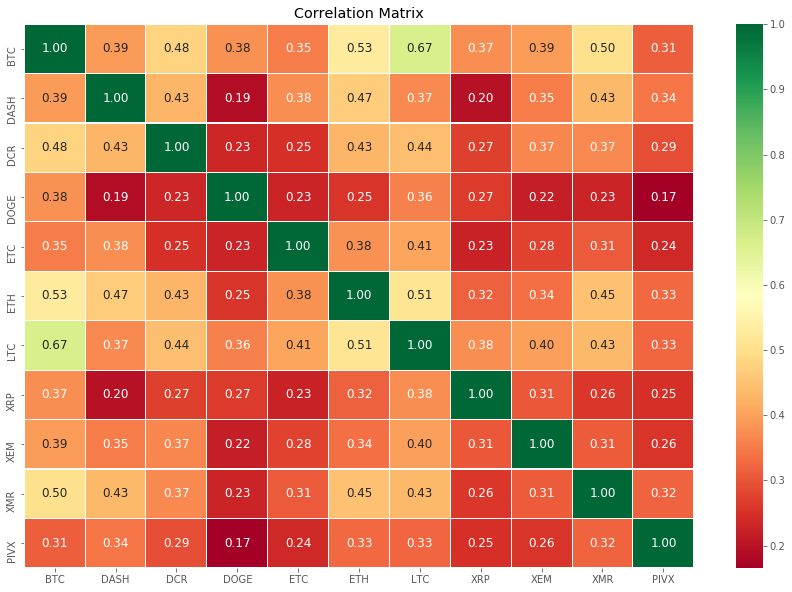

In [957]:
sns.heatmap(crypto_rets.corr(), 
            cmap='RdYlGn', annot=True, fmt='0.2f', annot_kws={"size": 12},
            linewidths = 0.1, linecolor='white')
plt.title('Correlation Matrix')

Text(0.5, 1.0, 'Autocorrelation of Returns by lags')

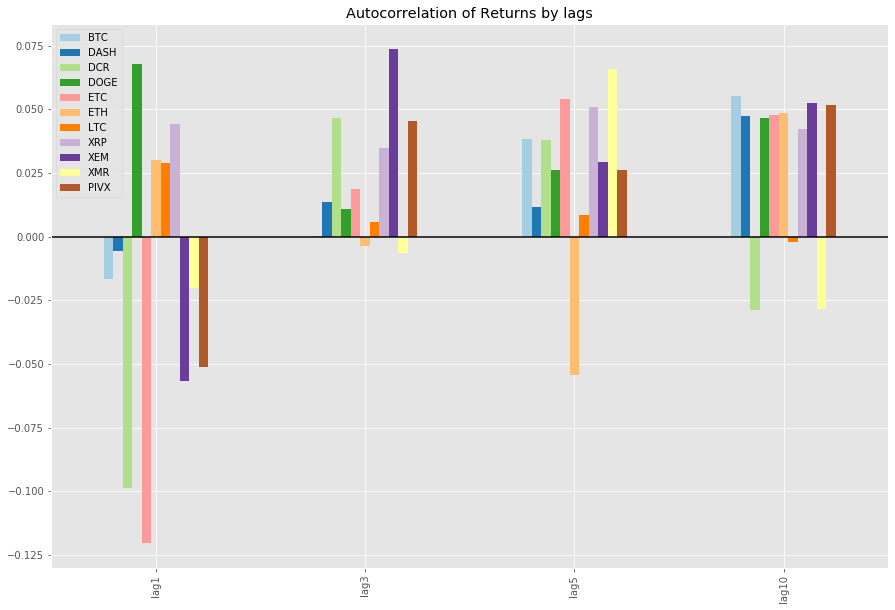

In [994]:
pd.concat({
    'lag'+str(l) :(crypto_rets).apply(lambda x: x.autocorr(l), raw=False) for l in [1, 3, 5, 10]
            }, axis=1).T.plot(kind='bar',cmap=cmap)
plt.axhline(0, color='black')
plt.title('Autocorrelation of Returns by Lags')

Text(0.5, 1.0, 'Autocorrelation of Squared Returns by lags')

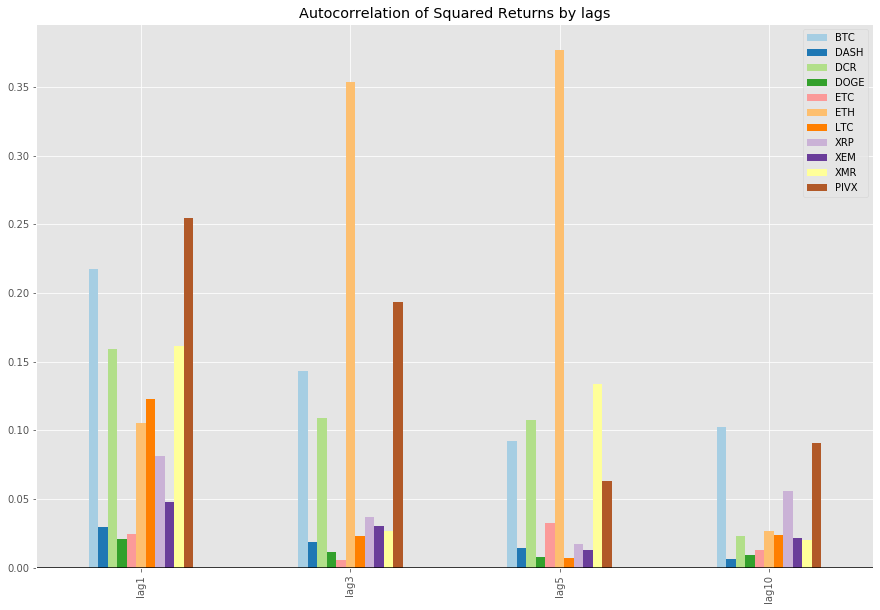

In [1005]:
pd.concat({
    'lag'+str(l) :(crypto_rets**2).apply(lambda x: x.autocorr(l), raw=False) for l in [1, 3, 5, 10]
            }, axis=1).T.plot(kind='bar',cmap=cmap)
plt.axhline(0, color='black')
plt.title('Autocorrelation of Squared Returns by lags')

           Vol Ratio     Hurst
Vol Ratio   1.000000  0.754545
Hurst       0.754545  1.000000


Text(0.5, 1.0, 'Hurst vs Vol Ratio (in logs)')

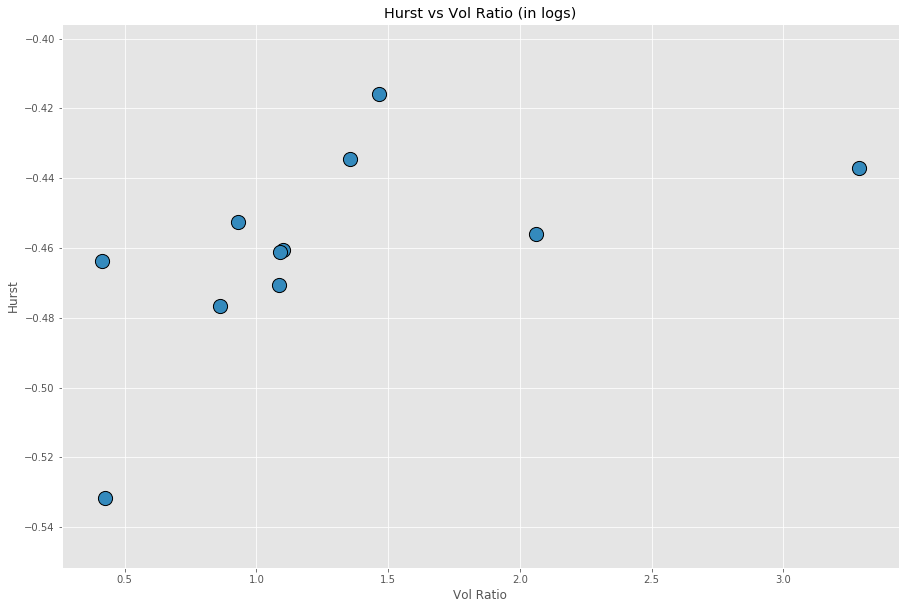

In [1136]:
autocorr_df = ((crypto_rets+1).cumprod().resample('Q').last().pct_change().std()*np.sqrt(4)).\
            divide((crypto_rets+1).cumprod().resample('B').last().pct_change().std()*np.sqrt(252)).to_frame('Vol Ratio')
autocorr_df['Hurst'] = (crypto_rets+1).cumprod().dropna().apply(np.log).apply(sh.get_hurst_exponent, args=(100,), raw=True)

print(autocorr_df.corr('spearman'))
autocorr_df.apply(np.log).plot(kind='scatter', 
                               y='Hurst',
                               x='Vol Ratio',
                               lw=1,s=200,
                               edgecolors= 'black')
plt.title('Hurst vs Vol Ratio (in logs)')

Text(0.5, 1, 'Eigenvectors - Top 3 PCs')

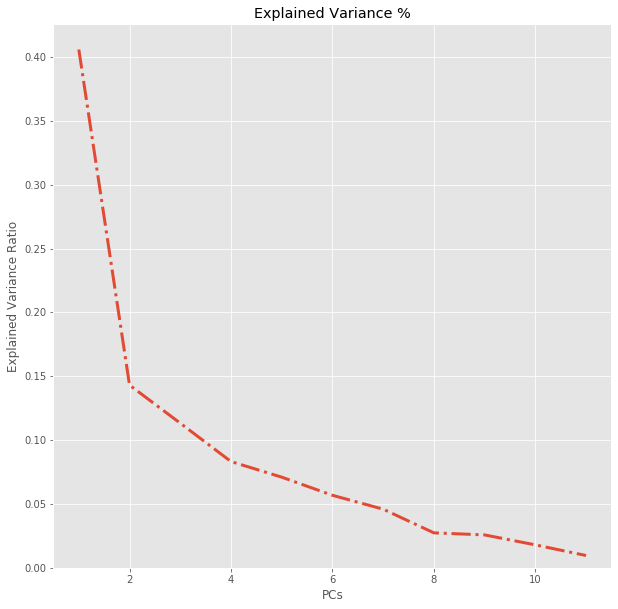

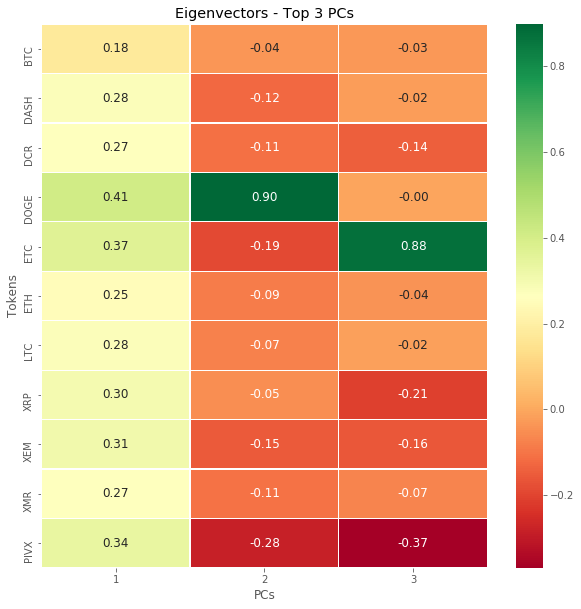

In [1238]:
crypto_pca = PCA(n_components=crypto_rets.shape[1],
                svd_solver='full').fit((crypto_rets.dropna()-crypto_rets.dropna().mean()))
eigen_df = pd.DataFrame(crypto_pca.components_, columns=crypto_rets.columns)
eigen_df.index = eigen_df.index+1

f, ax = plt.subplots(figsize=(10,10))
plt.plot(list(range(1, crypto_rets.shape[1]+1)),
         crypto_pca.explained_variance_ratio_, linestyle='dashdot', lw=3)
plt.title('Explained Variance %')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')
plt.ylim([0, None])

f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(eigen_df.loc[:3,:].T, ax=ax,
            cmap='RdYlGn', annot=True, fmt='0.2f', annot_kws={"size": 12},
            linewidths = 0.1, linecolor='white')
plt.xlabel('PCs')
plt.ylabel('Tokens')
plt.title('Eigenvectors - Top 3 PCs')

In [73]:
vol_tgt = 0.30
rebal_freq = 'B'
tau = 252

resamp_rets = (crypto_rets+1).cumprod().resample(rebal_freq).last().pct_change()
corr_df = resamp_rets.ewm(halflife=int(252), min_periods=21).corr().dropna()
vol_df = resamp_rets.ewm(halflife=int(63), min_periods=21).std().dropna()

vol_tgt_stats = ((vol_tgt/np.sqrt(252))/vol_df).shift(1).multiply(resamp_rets).apply(get_stats, args=(252,))

Text(0.5, 1.0, 'Sharpe Ratios')

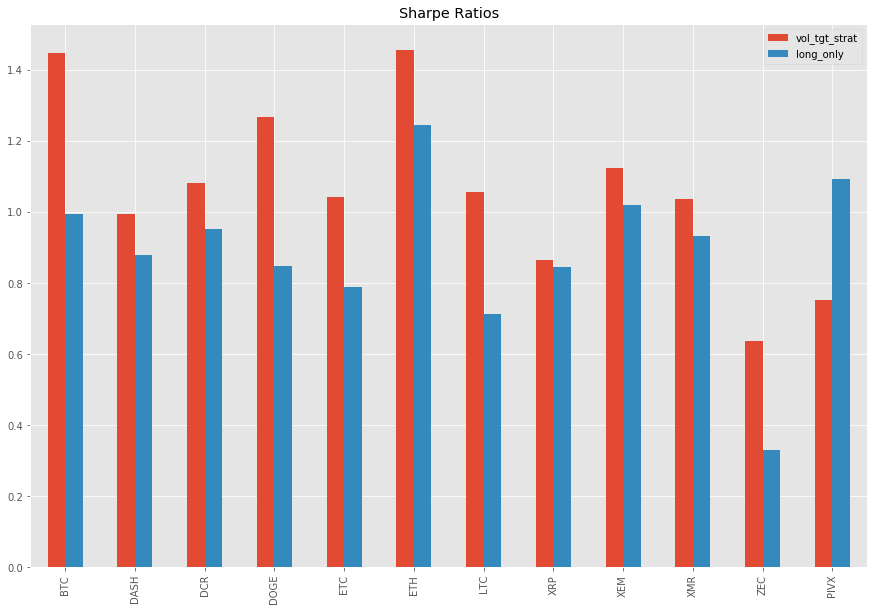

In [85]:
pd.concat([vol_tgt_stats.loc['SR'].to_frame('vol_tgt_strat'), 
           ret_stats.loc['SR'].to_frame('long_only')], axis=1).plot(kind='bar')
plt.title('Sharpe Ratios')

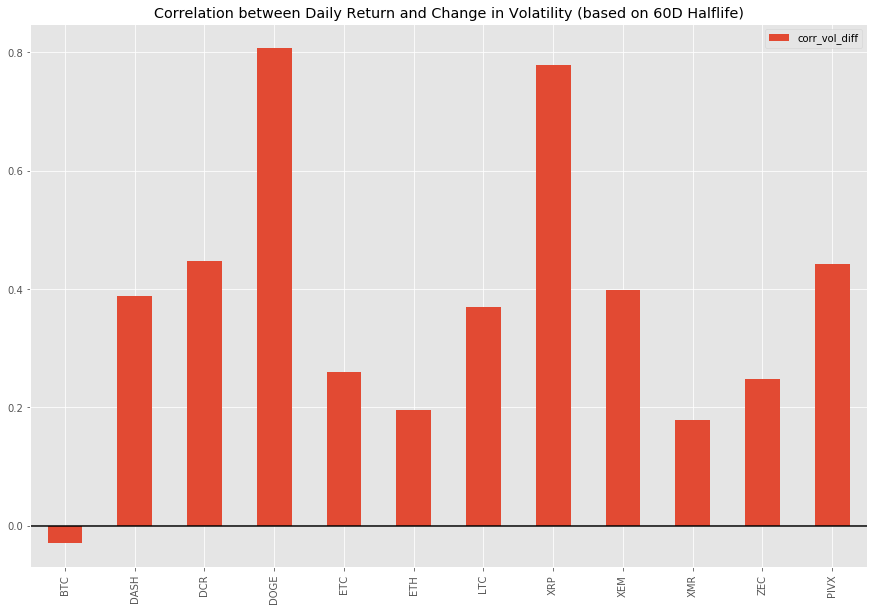

In [38]:
resamp_rets.apply(
    lambda x: pd.concat([x, vol_df.diff()[x.name]], axis=1).corr().iloc[0,1],
    axis=0).to_frame('corr_vol_diff').plot(kind='bar')
plt.title('Correlation between Daily Return and Change in Volatility (based on 60D Halflife)')
plt.axhline(0, color='black')

In [53]:
def get_agg_signals(idx, ls=False):
    ramom_cta = cum_rets_df[[idx]].dropna(how='all').apply(get_ramom_cta, args=(ls,))
    emac_cta = cum_rets_df[[idx]].dropna(how='all').apply(get_emac_cta, args=(ls,))
    emabo_cta = cum_rets_df[[idx]].dropna(how='all').apply(get_emabo_cta, args=(ls,))
    maxbo_cta = cum_rets_df[[idx]].dropna(how='all').apply(get_max_breakout_cta, args=(ls,))
    return pd.concat([ramom_cta, emac_cta, emabo_cta,
                      maxbo_cta], axis=1).median(axis=1)


In [71]:
cum_rets_df = (resamp_rets+1).cumprod()
cta_sig_lo_ts = cum_rets_df.apply(lambda x: get_agg_signals(x.name)).resample(rebal_freq).last().dropna().\
                apply(lambda x: np.round(x/0.20,0)*0.20)
cta_sig_ls_ts = cum_rets_df.apply(lambda x: get_agg_signals(x.name, True)).resample(rebal_freq).last().dropna().\
                apply(lambda x: np.round(x/0.20,0)*0.20)

cta_sig_lo_ts.shift(2).multiply(resamp_rets).apply(get_stats, args=(252,))

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XRP,XEM,XMR,ZEC,PIVX
Arith. Mean,0.640352,0.757649,0.966137,1.559019,0.988349,1.023429,0.875012,1.408469,0.928547,0.662232,0.591881,1.285079
Compound Mean,0.399682,0.389408,0.545895,0.840064,0.549561,0.692435,0.490573,0.665826,0.517911,0.342489,0.272137,0.712514
Volatility,0.398014,0.664381,0.718344,1.293439,0.736037,0.546272,0.670507,1.453019,0.701614,0.595369,0.628754,0.941241
SR,1.608866,1.140384,1.344951,1.205329,1.342798,1.873478,1.305001,0.969339,1.323443,1.112305,0.941356,1.365303
t-Stat,3.796195,2.690788,3.173474,2.844030,3.168394,4.420559,3.079211,2.287201,3.122726,2.624536,2.221173,3.221496
Skew Sharpe,1.147189,0.793349,0.945914,0.841436,0.944292,1.353354,0.915871,0.668324,0.929725,0.772662,0.648098,0.961264
Max DD,0.524113,0.689247,0.506389,0.662522,0.655751,0.589000,0.607334,0.720611,0.766126,0.612329,0.695058,0.750028
Calmar,1.221782,1.099241,1.907893,2.353158,1.507202,1.737570,1.440742,1.954547,1.212003,1.081496,0.851556,1.713376
Skewness,0.330612,2.463202,3.216708,14.816399,2.138482,1.714279,3.317517,22.843208,2.574683,1.947570,1.795215,4.723469
Kurtosis,4.242399,19.576435,28.987069,346.984374,16.795118,14.658405,30.807429,702.816873,21.919819,19.722450,14.679199,51.016154


In [69]:
cta_sig_ls_ts.shift(2).multiply(resamp_rets).apply(get_stats, args=(252,))

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XRP,XEM,XMR,ZEC,PIVX
Arith. Mean,0.270151,0.336970,0.383718,0.518303,0.437020,0.387517,0.387979,0.535285,0.412554,0.113168,0.183390,0.587729
Compound Mean,0.152927,0.161143,0.189487,0.271756,0.223478,0.227564,0.210870,0.228930,0.226661,0.034397,0.056615,0.297826
Volatility,0.255731,0.421470,0.440995,0.511456,0.457119,0.302487,0.380908,0.754666,0.380712,0.340302,0.426781,0.579148
SR,1.056388,0.799511,0.870119,1.013387,0.956032,1.281101,1.018562,0.709301,1.083639,0.332550,0.429704,1.014818
t-Stat,2.492596,1.886483,2.053086,2.391133,2.255801,3.022818,2.403344,1.673628,2.556897,0.784668,1.013907,2.394509
Skew Sharpe,0.731654,0.546573,0.900234,0.700292,0.658698,1.336946,0.704059,0.482865,0.751608,0.223307,0.389439,0.701333
Max DD,0.221046,0.459673,0.423494,0.381774,0.430957,0.213918,0.260631,0.460742,0.413375,0.442490,0.473540,0.571092
Calmar,1.222148,0.733064,0.906076,1.357618,1.014070,1.811518,1.488614,1.161791,0.998014,0.255752,0.387274,1.029133
Skewness,0.312182,1.063084,2.185033,6.342224,2.419326,0.994614,4.239208,20.764526,1.001901,1.671124,-0.050279,5.244372
Kurtosis,12.980663,17.096721,25.238510,77.495198,19.905805,10.606539,59.418717,612.094817,12.259322,20.523547,10.458518,79.231087


In [951]:
def get_agg_signals(idx):
    return pd.concat([ramom_cta[idx], emac_cta[idx], 
               emabo_cta[idx], maxbo_cta[idx]], axis=1).median(axis=1)

ramom_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_ramom_cta, args=(False,))
emac_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_emac_cta, args=(False,))
emabo_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_emabo_cta, args=(False,))
maxbo_cta = crypto_df[sub_cryptos].dropna(how='all').apply(get_max_breakout_cta, args=(False,))
cta_sig_ts = crypto_rets.apply(lambda x: get_agg_signals(x.name)).resample(rebal_freq).last().dropna()

corr_df = resamp_rets.ewm(com=int(252), min_periods=21).corr().dropna()
vol_df = resamp_rets.ewm(com=int(63), min_periods=21).std().dropna()

cov_df = corr_df.groupby(level=0, axis=0).apply(
                lambda x: pd.DataFrame(dfah.corr2cov(vol_df.loc[x.name].values, x.values),
                                       index=x.columns,
                                       columns=x.columns))

model_weights = cov_df.loc[cta_sig_ts.dropna().index[0]:].groupby(level=0, axis=0).apply(
                lambda x: pd.Series(get_erc(x.values,
                                             vol_tgt=vol_tgt/np.sqrt(tau),
                                             signal=cta_sig_ts.loc[x.name].values), 
                                    index=x.columns))
#cta_sig_ts.loc[x.name].values
strat_df = model_weights.resample(rebal_freq).last().shift(1).\
                    multiply(resamp_rets).sum(axis=1).dropna(how='all').to_frame('longout_crypto')
strat_df['long_crypto'] = resamp_rets.mean(axis=1)
strat_df.loc['2017/01':].apply(get_stats, args=(252,))

,longout_crypto,long_crypto
Arith. Mean,0.700114,1.552610
Compound Mean,0.872357,2.073263
Volatility,0.383218,0.921049
SR,1.826933,1.685698
t-Stat,4.275254,3.944746
Skew Sharpe,1.859859,1.729765
Max DD,0.539807,0.909221
Calmar,1.296971,1.707626
Skewness,1.247309,0.006713
Kurtosis,20.439975,5.924559


In [45]:
lkbks = [[5, 21]]
crypto_prices = (crypto_rets+1).cumprod().dropna()

btstrp_df = pd.DataFrame()
bootstrap_ix = pd.DataFrame(get_stationary_block_samples(crypto_rets, 3*21, 252*10, 1000))
for sim in range(bootstrap_ix.shape[1]):
    btstrp_df = pd.concat([btstrp_df, 
                           crypto_rets['BTC'].iloc[bootstrap_ix.iloc[:,sim]].reset_index(drop=True).to_frame('sim_'+str(sim))], axis=1)
btstrp_df.index = pd.date_range('2022-04-05', periods=btstrp_df.shape[0], freq='D')
strat_sims = btstrp_df.apply(get_strat_rets)

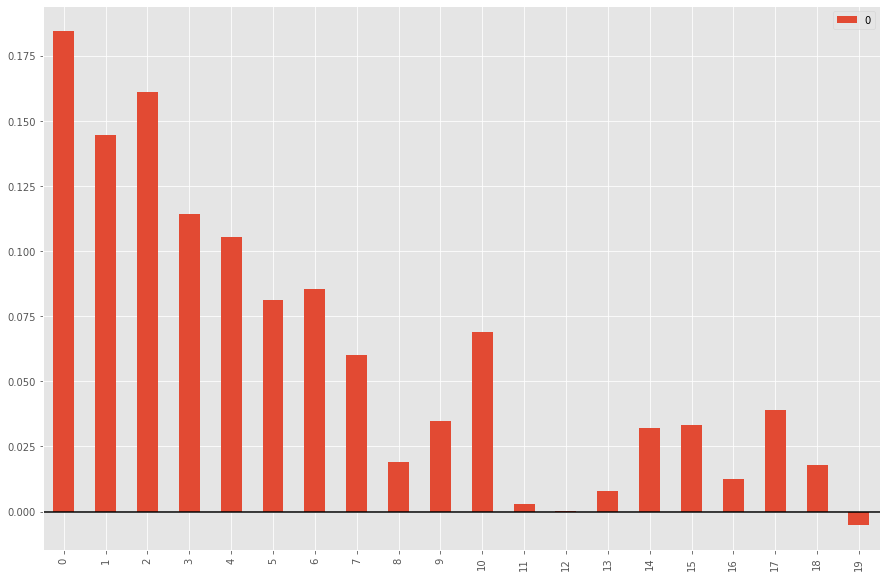

In [11]:
pd.DataFrame([(crypto_rets['ETH']**2).autocorr(ix) for ix in range(1,21)]).plot(kind='bar')
plt.axhline(0, color='black')

Text(0.5, 0, 'Geometric Returns')

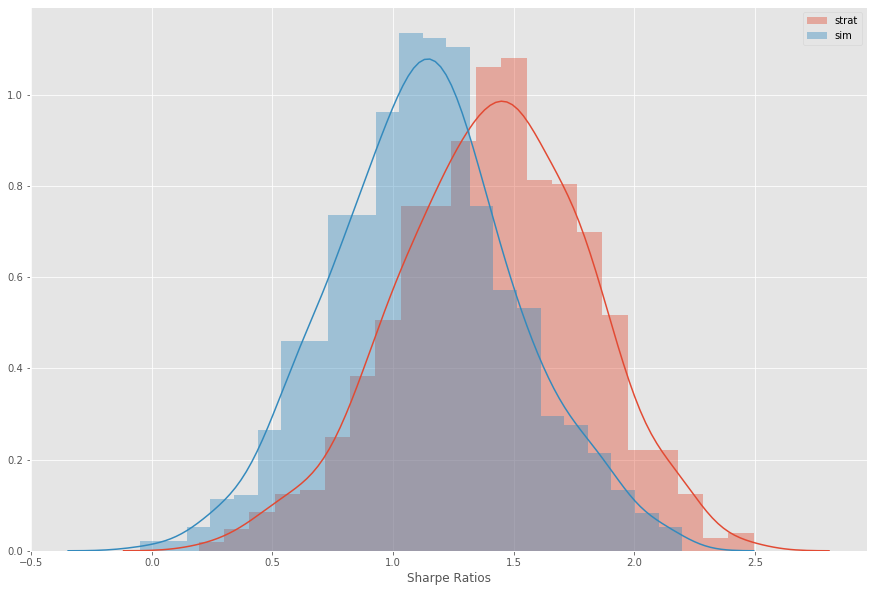

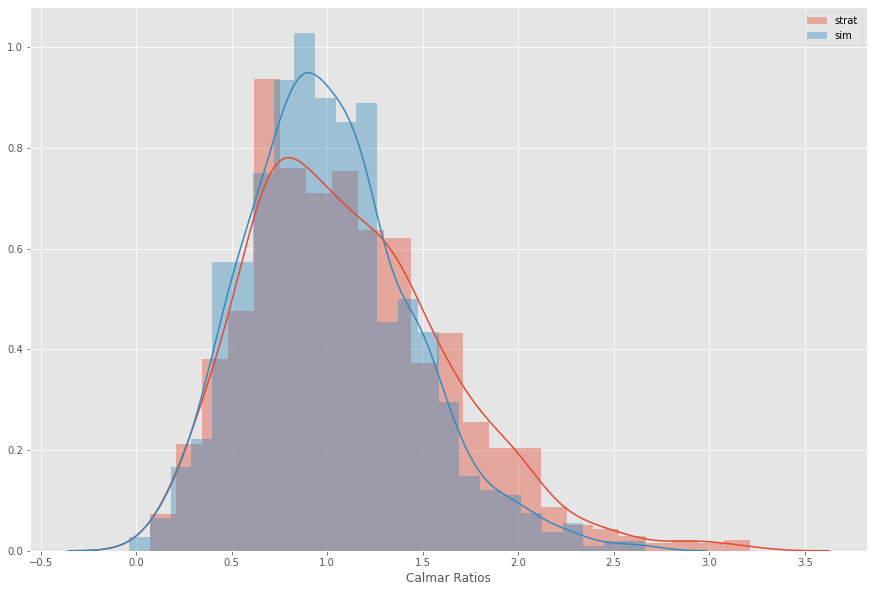

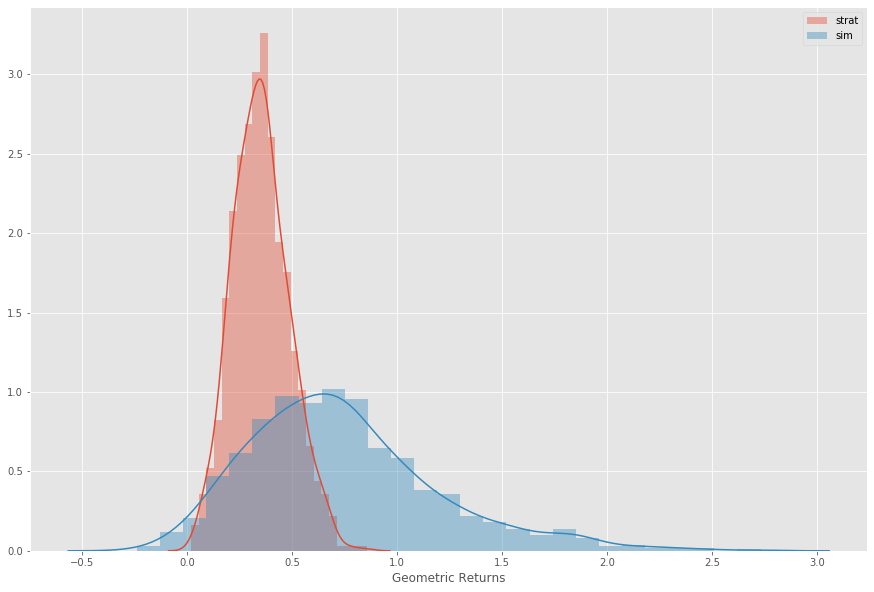

In [53]:
sharpe_df = pd.concat([strat_sims.dropna().apply(lambda x: x.mean()*np.sqrt(252)/x.std()),
                       btstrp_df.dropna().apply(lambda x: x.mean()*np.sqrt(252)/x.std())], axis=1)
calmar_df = pd.concat([strat_sims.dropna().apply(lambda x: (x.mean()*252)/(((1+x).cumprod().divide((1+x).cumprod().cummax())-1).abs().max())),
                       btstrp_df.dropna().apply(lambda x: (x.mean()*252)/((1+x).cumprod().divide((1+x).cumprod().cummax())-1).abs().max())], axis=1)
compound_df = pd.concat([strat_sims.dropna().apply(lambda x: (1+x).cumprod().iloc[-1]**(252/len(x))-1),
                       btstrp_df.dropna().apply(lambda x: (1+x).cumprod().iloc[-1]**(252/len(x))-1)], axis=1)


sharpe_df.columns = ['strat', 'sim']
calmar_df.columns = ['strat', 'sim']
compound_df.columns = ['strat', 'sim']

f1, ax1 = plt.subplots()
sns.distplot(sharpe_df['strat'], ax=ax1)
sns.distplot(sharpe_df['sim'], ax=ax1)
plt.legend(['strat', 'sim'])
plt.xlabel('Sharpe Ratios')

f2, ax2 = plt.subplots()
sns.distplot(calmar_df['strat'], ax=ax2)
sns.distplot(calmar_df['sim'], ax=ax2)
plt.legend(['strat', 'sim'])
plt.xlabel('Calmar Ratios')

f3, ax3 = plt.subplots()
sns.distplot(compound_df['strat'], ax=ax3)
sns.distplot(compound_df['sim'], ax=ax3)
plt.legend(['strat', 'sim'])
plt.xlabel('Geometric Returns')


In [81]:
(rets_df+1).cumprod().apply(get_bo_sig)

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
Date,,,,,,,,,,
2016-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-04-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2022-04-07,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0
2022-04-08,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0


(-0.922358700908047, 1.3511670134802582)

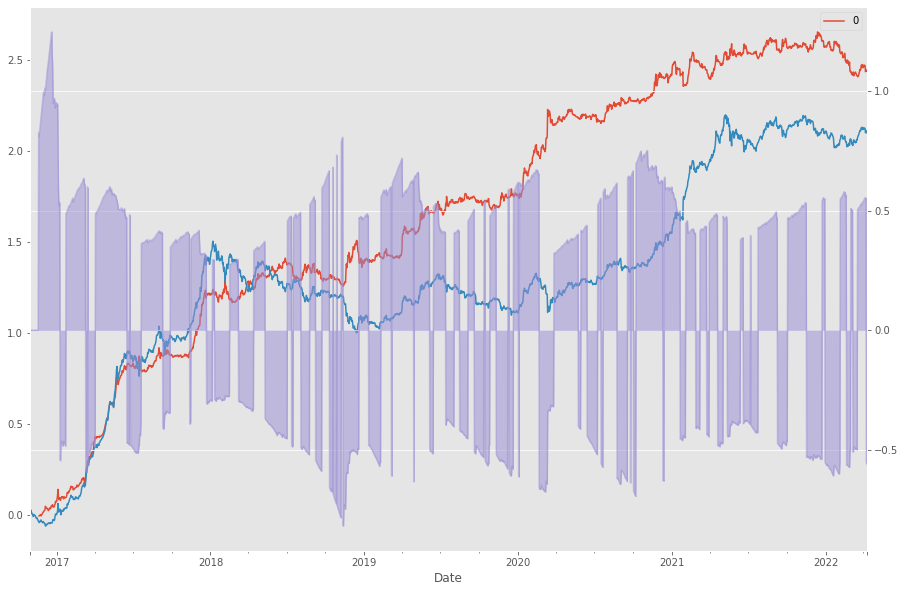

In [87]:
vol_tgt = 0.30

f, ax = plt.subplots()
position_size = ((rets_df+1).cumprod().apply(get_bo_sig)).multiply((vol_tgt/crypto_vols), axis=0)
position_size.shift(1).multiply(crypto_rets).mean(axis=1).dropna().cumsum().plot(ax=ax)
crypto_rets.mean(axis=1).to_frame().apply(lambda x: (0.013/x.std())*x).cumsum().plot(ax=ax)

position_size['BTC'].plot.area(ax=ax, stacked=False, secondary_y=True, alpha=0.5)
plt.ylim(None, None)

In [85]:
position_size.shift(1).multiply(crypto_prices.pct_change()).dropna().corr()

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
BTC,1.000000,0.424057,0.381190,0.294853,0.369686,0.471339,0.428509,0.281172,0.492433,0.345338
DASH,0.424057,1.000000,0.235458,0.234985,0.368246,0.416582,0.395316,0.251953,0.458783,0.507778
DCR,0.381190,0.235458,1.000000,0.196073,0.247199,0.322377,0.289637,0.259559,0.310496,0.253149
DOGE,0.294853,0.234985,0.196073,1.000000,0.255513,0.252543,0.256900,0.187807,0.254673,0.233841
ETC,0.369686,0.368246,0.247199,0.255513,1.000000,0.416509,0.383826,0.272439,0.347001,0.394176
ETH,0.471339,0.416582,0.322377,0.252543,0.416509,1.000000,0.377399,0.301135,0.428481,0.380495
LTC,0.428509,0.395316,0.289637,0.256900,0.383826,0.377399,1.000000,0.264307,0.344257,0.338200
XEM,0.281172,0.251953,0.259559,0.187807,0.272439,0.301135,0.264307,1.000000,0.292424,0.283941
XMR,0.492433,0.458783,0.310496,0.254673,0.347001,0.428481,0.344257,0.292424,1.000000,0.377329
ZEC,0.345338,0.507778,0.253149,0.233841,0.394176,0.380495,0.338200,0.283941,0.377329,1.000000


In [77]:
bo_signals.multiply(ivol_weights).shift(1).multiply(crypto_prices.pct_change()).dropna().apply(get_stats, args=(252,))

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
Arith. Mean,0.104604,0.084346,0.067861,0.124972,0.092581,0.121614,0.093747,0.113500,0.086489,0.062414
Compound Mean,0.107546,0.085204,0.067908,0.129285,0.093792,0.126305,0.094594,0.115776,0.087261,0.061944
Volatility,0.069904,0.072042,0.065708,0.082749,0.076676,0.072848,0.083091,0.090903,0.075385,0.068151
SR,1.496391,1.170796,1.032757,1.510243,1.207440,1.669416,1.128246,1.248581,1.147303,0.915812
t-Stat,4.181744,3.271851,2.886095,4.220454,3.374255,4.665270,3.152944,3.489226,3.206198,2.559286
Max DD,0.124655,0.091206,0.124796,0.076091,0.084199,0.110293,0.081789,0.098228,0.079069,0.119639
Calmar,0.839147,0.924786,0.543774,1.642398,1.099549,1.102638,1.146201,1.155469,1.093844,0.521681
Skewness,0.680575,3.766925,1.124635,5.516945,2.448654,0.961595,9.233667,14.336746,2.969214,2.360150
Kurtosis,8.903152,41.602567,7.090198,63.504704,24.422017,11.657502,208.507558,403.397500,40.535924,29.064602


In [86]:
position_size.shift(1).multiply(crypto_prices.pct_change()).dropna().apply(get_stats, args=(252,))

,BTC,DASH,DCR,DOGE,ETC,ETH,LTC,XEM,XMR,ZEC
Arith. Mean,0.366093,0.313738,0.193327,0.358464,0.276520,0.415757,0.310477,0.411937,0.263627,0.221797
Compound Mean,0.371734,0.301771,0.157237,0.300550,0.256042,0.444411,0.287498,0.431637,0.241401,0.196312
Volatility,0.317898,0.318563,0.307806,0.392225,0.313268,0.310681,0.345218,0.335086,0.309615,0.293036
SR,1.151605,0.984855,0.628081,0.913923,0.882697,1.338209,0.899363,1.229348,0.851468,0.756893
t-Stat,3.218222,2.752228,1.755206,2.554006,2.466743,3.739696,2.513318,3.435477,2.379472,2.115177
Max DD,0.325624,0.451069,0.446845,0.635721,0.426135,0.323766,0.439959,0.295885,0.361786,0.327958
Calmar,1.124283,0.695544,0.432649,0.563869,0.648903,1.284126,0.705695,1.392220,0.728682,0.676297
Skewness,1.126920,1.370799,0.262140,-6.433200,0.967566,0.719711,3.221369,5.217749,1.077335,0.848370
Kurtosis,13.639576,13.333075,8.412211,227.552720,6.818852,6.769907,77.888239,98.292477,10.236940,6.349821


In [74]:
ivol_weights = crypto_vols.apply(lambda x: (1/x)/np.sum(1/x), axis=1)
bo_signals = (((rets_df+1).cumprod().apply(get_bo_sig)+1)/2)